# Outlier Detection with CIFAR10 using Alibi-Detect



## Conda env create

We create a conda environment for the runtime of our explainer from the `./artifacts/income_explainer/conda.yaml`
**This only needs to be done once**.

In [ ]:
!conda env create --name tempo-outlier-example --file ./artifacts/cifar10_outlier/conda.yaml

In [1]:
import cloudpickle
import tensorflow as tf
import matplotlib.pyplot as plt

from tempo.serve.metadata import ModelFramework
from tempo.serve.model import Model
from tempo.seldon.docker import SeldonDockerRuntime
from tempo.kfserving.protocol import KFServingV2Protocol, KFServingV1Protocol
from tempo.serve.utils import pipeline, predictmethod, model
from tempo.seldon.k8s import SeldonKubernetesRuntime
from tempo.kfserving.k8s import KFServingKubernetesRuntime
from tempo.serve.metadata import ModelFramework, KubernetesOptions
from alibi.utils.wrappers import ArgmaxTransformer
from typing import Any

import numpy as np
import os 
import pprint
import json

OUTLIER_FOLDER = os.getcwd()+"/artifacts/cifar10_outlier"
MODEL_FOLDER = os.getcwd()+"/artifacts/cifar10_model"
SVC_FOLDER = os.getcwd()+"/artifacts/svc"

In [2]:
import logging
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
tf.keras.backend.clear_session()
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Layer, Reshape, InputLayer
from tqdm import tqdm

from alibi_detect.models.losses import elbo
from alibi_detect.od import OutlierVAE
from alibi_detect.utils.fetching import fetch_detector
from alibi_detect.utils.perturbation import apply_mask
from alibi_detect.utils.saving import load_detector
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image

In [3]:
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):  # pylint: disable=arguments-differ,method-hidden
        if isinstance(
            obj,
            (
                np.int_,
                np.intc,
                np.intp,
                np.int8,
                np.int16,
                np.int32,
                np.int64,
                np.uint8,
                np.uint16,
                np.uint32,
                np.uint64,
            ),
        ):
            return int(obj)
        elif isinstance(obj, (np.float_, np.float16, np.float32, np.float64)):
            return float(obj)
        elif isinstance(obj, (np.ndarray,)):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)


In [4]:
def show_image(X):
    plt.imshow(X.reshape(32, 32, 3))
    plt.axis('off')
    plt.show()

In [5]:
train, test = tf.keras.datasets.cifar10.load_data()
X_train, y_train = train
X_test, y_test = test

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


## Create Tempo Artifacts

In [6]:
cifar10_model = Model(
        name="resnet32",
        runtime=SeldonDockerRuntime(protocol=KFServingV1Protocol()),
        platform=ModelFramework.Tensorflow,
        uri="gs://seldon-models/tfserving/cifar10/resnet32",
        local_folder=MODEL_FOLDER,
    )

@model(
        name="outlier",
        platform=ModelFramework.TempoPipeline,
        runtime=SeldonDockerRuntime(protocol=KFServingV2Protocol()),
        uri="gs://seldon-models/tempo/cifar10/outlier",
        conda_env="tempo-outlier-example",
        local_folder=OUTLIER_FOLDER,
    )
class OutlierModel(object):
    
    def __init__(self):
        self.loaded = False
        
    def load(self):
        if "MLSERVER_MODELS_DIR" in os.environ:
            models_folder = "/mnt/models"
        else:
            models_folder = OUTLIER_FOLDER
        self.od = load_detector(models_folder+"/cifar10")
        self.loaded = True
        
    def unload(self):
        self.od = None
        self.loaded = False
        
    @predictmethod
    def outlier(self, payload: np.ndarray) -> dict:
        if not self.loaded:
            self.load()
        print("Outlier called")
        od_preds = self.od.predict(payload,
                      outlier_type='instance',    # use 'feature' or 'instance' level
                      return_feature_score=True,  # scores used to determine outliers
                      return_instance_score=True)
        
        return json.loads(json.dumps(od_preds, cls=NumpyEncoder))
    
outlier = OutlierModel()

@pipeline(
        name="cifar10-service",
        runtime=SeldonDockerRuntime(protocol=KFServingV2Protocol()),
        uri="gs://seldon-models/tempo/cifar10/svc",
        conda_env="tempo-outlier-example",
        local_folder=SVC_FOLDER,
        models=[outlier, cifar10_model]
    )
class Cifar10(object):
        
    @predictmethod
    def predict(self, payload: np.ndarray) -> np.ndarray:
        r = outlier(payload=payload)
        if r["data"]["is_outlier"][0]:
            return np.array([])
        else:
            return cifar10_model(payload)

        
svc = Cifar10()

In [7]:
idx = 1
X = X_train[idx:idx+1]
np.random.seed(0) 
X_mask, mask = apply_mask(X.reshape(1, 32, 32, 3),
                                  mask_size=(10,10),
                                  n_masks=1,
                                  channels=[0,1,2],
                                  mask_type='normal',
                                  noise_distr=(0,1),
                                  clip_rng=(0,1))

## Test on docker with local pipelines

In [ ]:
cifar10_model.download()

In [ ]:
cifar10_model.deploy()
cifar10_model.wait_ready()

In [ ]:
idx = 1
X = X_test[idx].reshape(1, 32, 32, 3)
plt.imshow(X.reshape(32, 32, 3))
plt.axis('off')
plt.show()
print("class:",class_names[y_test[idx][0]])
print("prediction:",class_names[cifar10_model(X_test[idx:idx+1])[0].argmax()])

In [ ]:
show_image(X_mask)
r = outlier(payload=X_mask)
print("Is outlier:",r["data"]["is_outlier"][0] == 1)

In [ ]:
svc.predict(X_test[idx:idx+1])

In [ ]:
svc.predict(X_mask)

## Test on Outlier on docker 

In [ ]:
outlier.unload()
outlier.save(save_env=True)

In [ ]:
outlier.deploy()

In [ ]:
show_image(X_mask)
r = outlier.remote(payload=X_mask)
print("Is outlier:",r["data"]["is_outlier"][0] == 1)

In [ ]:
show_image(X_test[0:1])
r = outlier.remote(payload=X_test[0:1])
print("Is outlier:",r["data"]["is_outlier"][0] == 1)

## Test Svc on docker

In [ ]:
outlier.unload()
svc.save(save_env=True)

In [ ]:
svc.deploy()

In [ ]:
show_image(X_test[0:1])
svc.remote(payload=X_test[0:1])

In [ ]:
show_image(X_mask)
svc.remote(payload=X_mask)

## Deploy to Kubernetes

In [ ]:
!kubectl create namespace production

In [ ]:
!kubectl apply -f ../../../k8s/tempo-pipeline-rbac.yaml -n production

## Deploy to Kubernetes with Seldon

In [ ]:
k8s_options = KubernetesOptions(namespace="production")
k8s_v1_runtime = SeldonKubernetesRuntime(k8s_options=k8s_options, protocol=KFServingV1Protocol())
k8s_v2_runtime = SeldonKubernetesRuntime(k8s_options=k8s_options, protocol=KFServingV2Protocol())

cifar10_model.set_runtime(k8s_v1_runtime)
outlier.set_runtime(k8s_v2_runtime)
svc.set_runtime(k8s_v2_runtime)

In [ ]:
outlier.save(save_env=False)
outlier.upload()

In [ ]:
#svc.save(save_env=False)
svc.upload()

In [ ]:
svc.deploy()
svc.wait_ready()

In [ ]:
show_image(X_test[0:1])
svc.remote(payload=X_test[0:1])

In [ ]:
show_image(X_mask)
svc.remote(payload=X_mask)

In [ ]:
svc.undeploy()

## Deploy to Kubernetes with KFServing

In [8]:
k8s_options = KubernetesOptions(namespace="production")
k8s_v1_runtime = KFServingKubernetesRuntime(k8s_options=k8s_options, protocol=KFServingV1Protocol())
k8s_v2_runtime = KFServingKubernetesRuntime(k8s_options=k8s_options, protocol=KFServingV2Protocol())

cifar10_model.set_runtime(k8s_v1_runtime)
outlier.set_runtime(k8s_v2_runtime)
svc.set_runtime(k8s_v2_runtime)

Loading external kubernetes config
Loading external kubernetes config


In [ ]:
cifar10_model.deploy()
cifar10_model.wait_ready()

In [ ]:
idx = 1
X = X_test[idx].reshape(1, 32, 32, 3)
plt.imshow(X.reshape(32, 32, 3))
plt.axis('off')
plt.show()
print("class:",class_names[y_test[idx][0]])
print("prediction:",class_names[cifar10_model(X_test[idx:idx+1])[0].argmax()])

In [ ]:
outlier.save(save_env=True)
outlier.upload()

In [ ]:
outlier.deploy()
outlier.wait_ready()

In [ ]:
show_image(X_mask)
r = outlier.remote(payload=X_mask)
print("Is outlier:",r["data"]["is_outlier"][0] == 1)

In [9]:
svc.save(save_env=True)
svc.upload()

Packing environment at '/home/clive/anaconda3/envs/tempo-outlier-example' to '/home/clive/work/mlops/fork-tempo/docs/examples/outlier/artifacts/svc/environment.tar.gz'
[########################################] | 100% Completed |  1min 37.1s


In [10]:
svc.deploy()
svc.wait_ready()

True

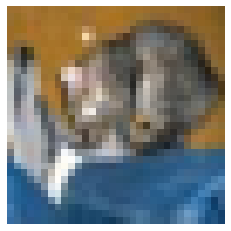

Endpoint is  http://34.77.224.192/v2/models/cifar10-service/infer
Loading external kubernetes config
Headers are {'Host': 'cifar10-service.production.example.com'}


array([[3.92252275e-09, 1.20454766e-11, 2.66008660e-09, 9.99992609e-01,
        2.52210419e-10, 5.40857116e-07, 6.75949923e-06, 4.75114522e-12,
        6.90868118e-09, 1.07274354e-11]])

In [11]:
show_image(X_test[0:1])
svc.remote(payload=X_test[0:1])

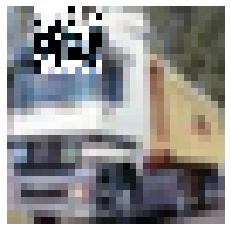

Endpoint is  http://34.77.224.192/v2/models/cifar10-service/infer
Loading external kubernetes config
Headers are {'Host': 'cifar10-service.production.example.com'}


array([], dtype=float64)

In [12]:
show_image(X_mask)
svc.remote(payload=X_mask)

In [ ]:
svc.undeploy()